### Modeling House Price with Regularized Linear Model 

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm,skew

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV,ElasticNet
#from xgboost import XGBRegressor,plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

#### Loading DataSet

In [8]:
df=pd.read_csv('/home/pandit/DataScience/CodingNest/Projects/Regression/House Price/train.csv')

In [9]:
df.shape

(1460, 81)

In [10]:
(df.isnull().sum()/len(df)).sort_values(ascending=False)[:20]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Utilities       0.000000
dtype: float64

In [11]:
df.drop(['PoolQC','MiscFeature','Alley','Fence','Id'],axis=1,inplace=True)

In [12]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu=180921.20 and sigma=79415.29


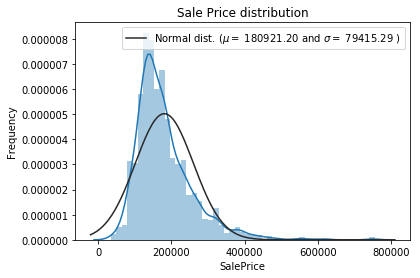

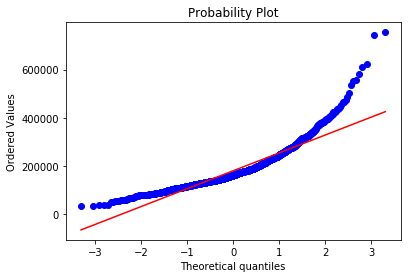

In [13]:
sns.distplot(df['SalePrice'],fit=norm)
#Get the fitted parameters used by the function
(mu,sigma)=norm.fit(df['SalePrice'])
print("\n mu={:.2f} and sigma={:.2f}".format(mu,sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show();


 mu=12.02 and sigma=0.40


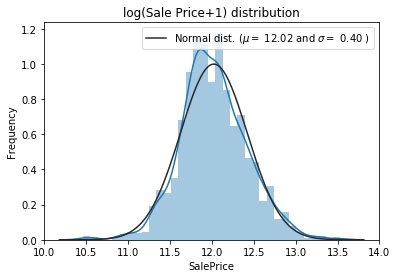

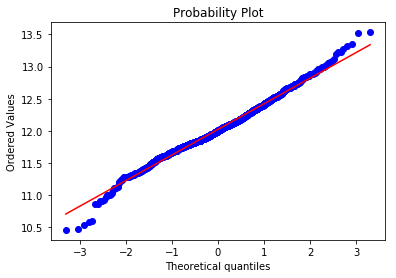

In [14]:
sns.distplot(np.log1p(df['SalePrice']),fit=norm)

# Get the fitted parameters used by the function
(mu,sigma)=norm.fit(np.log1p(df['SalePrice']))
print("\n mu={:.2f} and sigma={:.2f}".format(mu,sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(Sale Price+1) distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(df['SalePrice']), plot=plt)
plt.show();

#### Correlation between numeric features

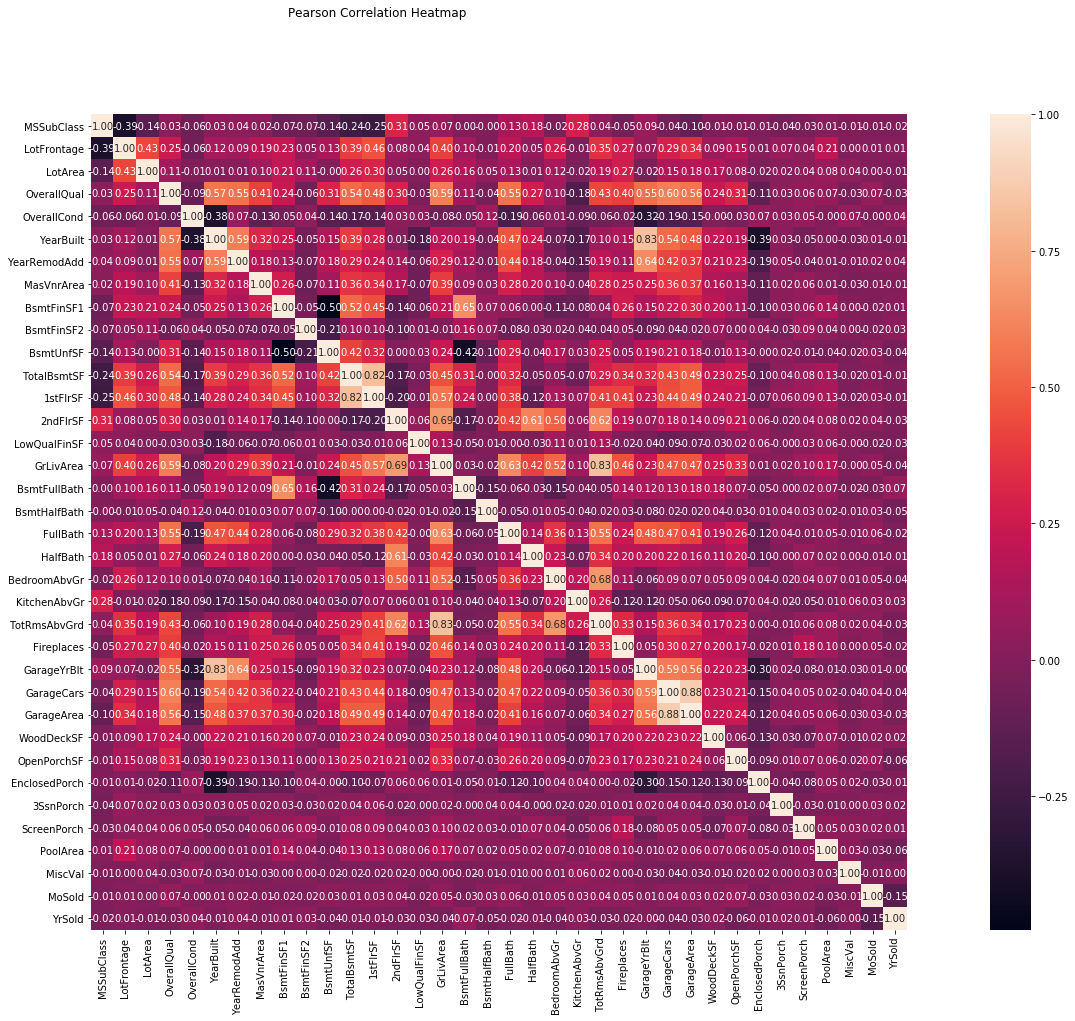

In [20]:
pd.set_option('precision',2)
plt.figure(figsize=(30,15))
sns.heatmap(df.drop(['SalePrice'],axis=1).corr(),annot=True,square=True,fmt='.2f')
plt.suptitle("Pearson Correlation Heatmap")
plt.show()

There exists strong correlations between some of the features. For example, GarageYrBlt and YearBuilt, TotRmsAbvGrd and GrLivArea, GarageArea and GarageCars are strongly correlated. They actually express more or less the same thing. I will let ElasticNetCV to help reduce redundancy.

#### Correlation between SalePrice and the Other numeric features

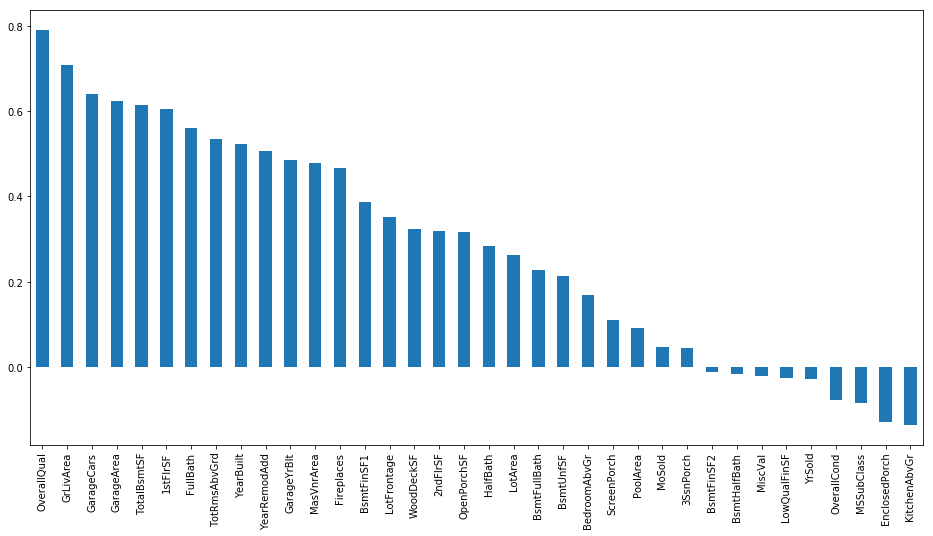

In [21]:
corr_with_sale_price=df.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(16,8))
corr_with_sale_price.drop('SalePrice').plot.bar()
plt.show()

The correlation of Sale Price with OverallQual is the greatest (around 0.8). Also GrLivArea presents a correlation of over 0.7, and GarageCars presents a correlation of over 0.6.

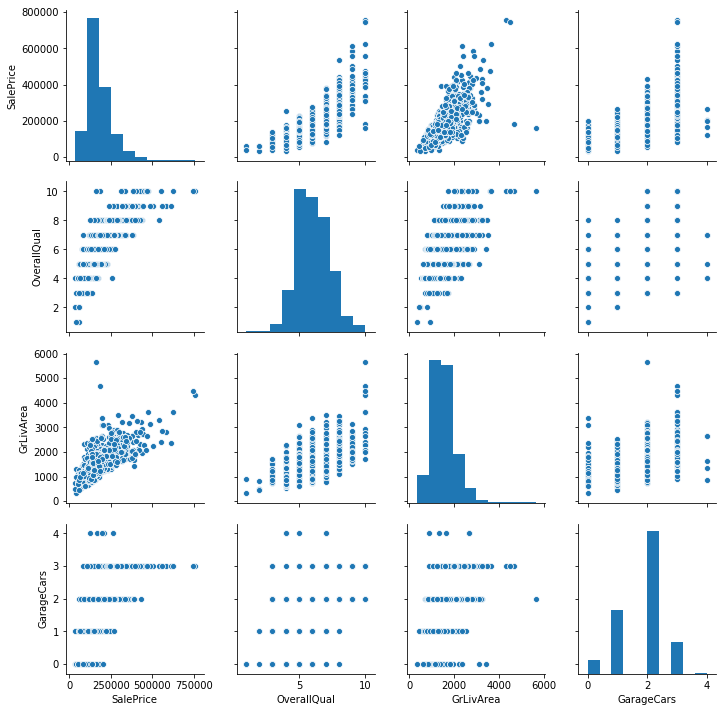

In [22]:
sns.pairplot(df[['SalePrice','OverallQual','GrLivArea','GarageCars']])
plt.show()

Log transform the target feature and all the other skewed numerical features.



In [23]:
df['SalePrice']=np.log1p(df['SalePrice'])

#log transform skewed numeric features:
numeric_feats=df.dtypes[df.dtypes!="object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])

In [41]:
X,y=df.drop(['SalePrice'],axis=1),df['SalePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

### ElasticNetCV

In [48]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

In [50]:
cv_model.fit(X_train,y_train)

In [51]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

In [52]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

In [53]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));